## 作業目標
* 嘗試比較用 color histogram 和 HOG 特徵來訓練的 SVM 分類器在 cifar10 training 和 testing data 上準確度的差別

In [1]:
import os
import keras
import tensorflow as tf
# 本範例不需使用 GPU, 將 GPU 設定為 "無"
# 使用第一張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = " 0 "
# 只使用 60% 的 GPU 記憶體
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

import numpy as np
import cv2 # 載入 cv2 套件
import matplotlib.pyplot as plt

train, test = keras.datasets.cifar10.load_data()

Using TensorFlow backend.


In [2]:
x_train, y_train = train
x_test, y_test = test
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# 調用方式

通過調用 cv2.calcHist(images, channels, mask, histSize, ranges) 函數來得到統計後的直方圖值

- images (list of array)：要分析的圖片

- channels：產生的直方圖類型。例：[0]→灰度圖，[0, 1, 2]→RGB三色。

- mask：optional，若有提供則僅計算 mask 部份的直方圖。

- histSize：要切分的像素強度值範圍，預設為256。每個channel皆可指定一個範圍。例如，[32,32,32] 表示RGB三個channels皆切分為32區段。

- ranges：像素的範圍，預設為[0,256]，表示<256。

#### 產生直方圖特徵的訓練資料

In [3]:
x_train_histogram = []
x_test_histogram = []

# 對於所有訓練資料
for i in range(len(x_train)):
    chans = cv2.split(x_train[i]) # 把圖像的 3 個 channel 切分出來
    # 對於所有 channel
    hist_feature = []
    for chan in chans:
        # 計算該 channel 的直方圖
        # cv2.calcHist計算並顯示直方圖
        hist = cv2.calcHist([chan], [0], None, [16], [0, 256]) # 切成 16 個 bin
        hist_feature.extend(hist.flatten())  # hist_feature.extend:將每個 hist.flatten() 加入 list
    # 把計算的直方圖特徵收集起來
    x_train_histogram.append(hist_feature)

# 對於所有測試資料也做一樣的處理
for i in range(len(x_test)):
    chans = cv2.split(x_test[i]) # 把圖像的 3 個 channel 切分出來
    # 對於所有 channel
    hist_feature = []
    for chan in chans:
        # 計算該 channel 的直方圖
        # cv2.calcHist計算並顯示直方圖
        hist = cv2.calcHist([chan], [0], None, [16], [0, 256]) # 切成 16 個 bin
        hist_feature.extend(hist.flatten())  # hist_feature.extend:將每個 hist.flatten() 加入 list
    x_test_histogram.append(hist_feature)

x_train_histogram = np.array(x_train_histogram)
x_test_histogram = np.array(x_test_histogram)


#### 產生 HOG 特徵的訓練資料
* HOG 特徵通過計算和統計圖像局部區域的梯度方向直方圖來構建特徵，具體細節不在我們涵蓋的範圍裡面，有興趣的同學請參考[補充資料](https://www.cnblogs.com/zyly/p/9651261.html)哦

In [7]:
# SZ=20
bin_n = 16 # Number of bins

def hog(img):
    #彩色影象轉為灰度影象
    #cv2.cvtColor顏色空間轉換
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate gradient，cv2.Sobel:Sobel運算元
    '''
    cv2.Sobel(img, ddepth, dx, dy)
    參數說明:
    img:需要處理的影象。
    ddepth:影象的深度，-1表示採用的是與原影象相同的深度。
    dx和dy表示的是求導的階數，0表示這個方向上沒有求導，一般為0、1、2。
    '''
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    # cv2.cartToPolar():笛卡爾坐標與極坐標之間的轉換
    mag, ang = cv2.cartToPolar(gx, gy)
    bins = np.int32(bin_n*ang/(2*np.pi))    # quantizing binvalues in(量化二元值) (0...16)
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    # np.bincount:bin的數量比x中的最大值大1，每個bin給出了索引值在x中出現的次數
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    # np.hstack:沿著水平方向將數組堆疊起來。
    hist = np.hstack(hists)     # hist is a 64 bit vector
    return hist.astype(np.float32)

x_train_hog = np.array([hog(x) for x in x_train])
x_test_hog = np.array([hog(x) for x in x_test])

#### SVM model
* SVM 是機器學習中一個經典的分類算法，具體細節有興趣可以參考 [該知乎上的解釋](https://www.zhihu.com/question/21094489)，我們這裡直接調用 opencv 中實現好的函數

#### 用 histogram 特徵訓練 SVM 模型
* 訓練過程可能會花點時間，請等他一下

In [8]:
SVM_hist = cv2.ml.SVM_create()
SVM_hist.setKernel(cv2.ml.SVM_LINEAR) # 使用預先定義的內核初始化
SVM_hist.setGamma(5.383) # 核函數的參數
SVM_hist.setType(cv2.ml.SVM_C_SVC) # SVM的類型,預設是：SVM.C_SVC
SVM_hist.setC(2.67) #SVM優化問題的參數C

# training
# SVM_hist.train訓練統計模型
SVM_hist.train(x_train_histogram, cv2.ml.ROW_SAMPLE, y_train) # cv2.ml.ROW_SAMPLE代表每一行是一個樣本

# prediction
_, y_hist_train = SVM_hist.predict(x_train_histogram)
_, y_hist_test = SVM_hist.predict(x_test_histogram)

#### 用 HOG 特徵訓練 SVM 模型
* 訓練過程可能會花點時間，請等他一下

In [9]:
SVM_hog = cv2.ml.SVM_create()
SVM_hog.setKernel(cv2.ml.SVM_LINEAR) # 使用預先定義的內核初始化
SVM_hog.setGamma(5.383) # 核函數的參數
SVM_hog.setType(cv2.ml.SVM_C_SVC) # SVM的類型,預設是：SVM.C_SVC
SVM_hog.setC(2.67) # SVM優化問題的參數C

# training
SVM_hog.train(x_train_hog, cv2.ml.ROW_SAMPLE, y_train) # cv2.ml.ROW_SAMPLE代表每一行是一個樣本

# prediction
_, y_hog_train = SVM_hog.predict(x_train_hog)
_, y_hog_test = SVM_hog.predict(x_test_hog)

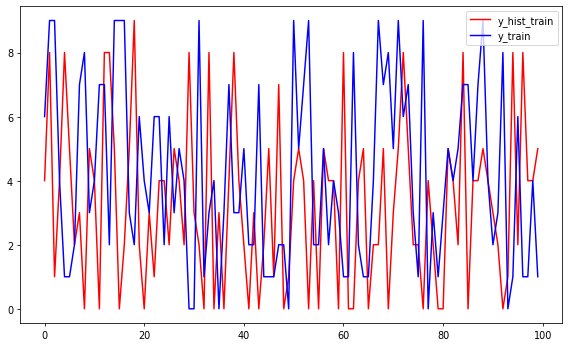

In [10]:
# figsize=(寬度英吋,高度英吋);dpi=每英吋多少像素
plt.figure(figsize=(10, 6), dpi=70)
plt.plot(y_hist_train[:100], color='red', label='y_hist_train')
plt.plot(y_train[:100], color='blue', label='y_train')
plt.legend(loc='upper right')
plt.show()

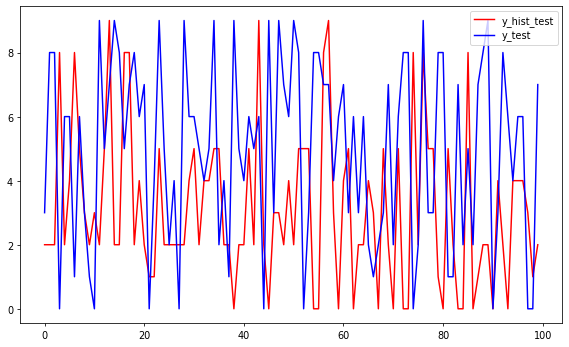

In [11]:
# figsize=(寬度英吋,高度英吋);dpi=每英吋多少像素
plt.figure(figsize=(10, 6), dpi=70)
plt.plot(y_hist_test[:100], color='red', label='y_hist_test')
plt.plot(y_test[:100], color='blue', label='y_test')
plt.legend(loc='upper right')
plt.show()

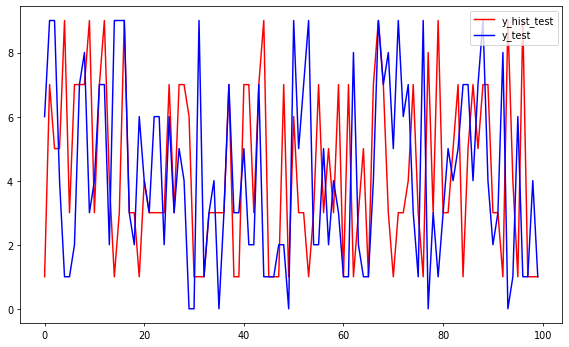

In [12]:
# figsize=(寬度英吋,高度英吋);dpi=每英吋多少像素
plt.figure(figsize=(10, 6), dpi=70)
plt.plot(y_hog_train[:100], color='red', label='y_hist_test')
plt.plot(y_train[:100], color='blue', label='y_test')
plt.legend(loc='upper right')
plt.show()

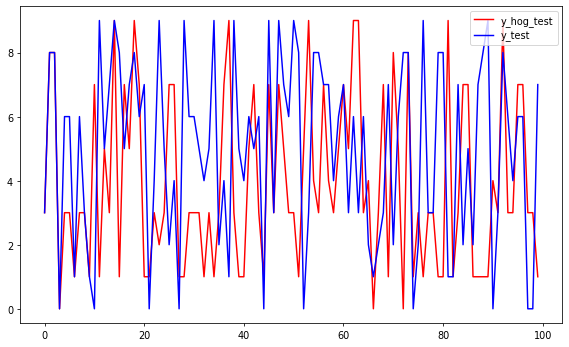

In [13]:
# figsize=(寬度英吋,高度英吋);dpi=每英吋多少像素
plt.figure(figsize=(10, 6), dpi=70)
plt.plot(y_hog_test[:100], color='red', label='y_hog_test')
plt.plot(y_test[:100], color='blue', label='y_test')
plt.legend(loc='upper right')
plt.show()